## Supervised Learning - Image Recognition with Support Vector Machines

_这个案例将演示用支持向量机来做人脸识别。我们将会用到Olivetti faces 数据集。_

先加载相关的包。

In [1]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


加载olivetti faces 数据集。

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# fetch the faces data
data_home='data'
faces = fetch_olivetti_faces(data_home)

print(faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



来看看这些数据，faces.images有400张人脸图片，每张图片由64x64像素的矩阵组成。
faces.data具有相同的数据，但是每行为4096个属性而不是矩阵（4096 = 64x64）

In [3]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)

dict_keys(['data', 'target', 'images', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)


我们不需要做数据处理，因为数据已经标准化了。

In [4]:
print(np.max(faces.data))
print(np.min(faces.data))
print(np.mean(faces.data))

1.0
0.0
0.5470426


绘制前20个图像。 数据集中有40个人，每个人有10个不同的图像。

In [5]:
def print_faces(images, target, top_n):
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        p.text(0, 14, str(target[i]))
        p.text(0, 60, str(i))
    

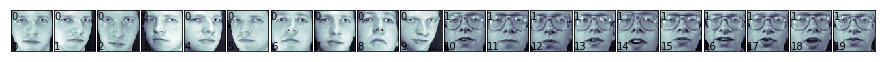

In [6]:
print_faces(faces.images, faces.target, 20)

在20x20的矩阵中绘制所有的人脸，对于每个人脸，我们将它的目标值放在左上角，并且在左下角进行索引。这会要一二十秒时间。

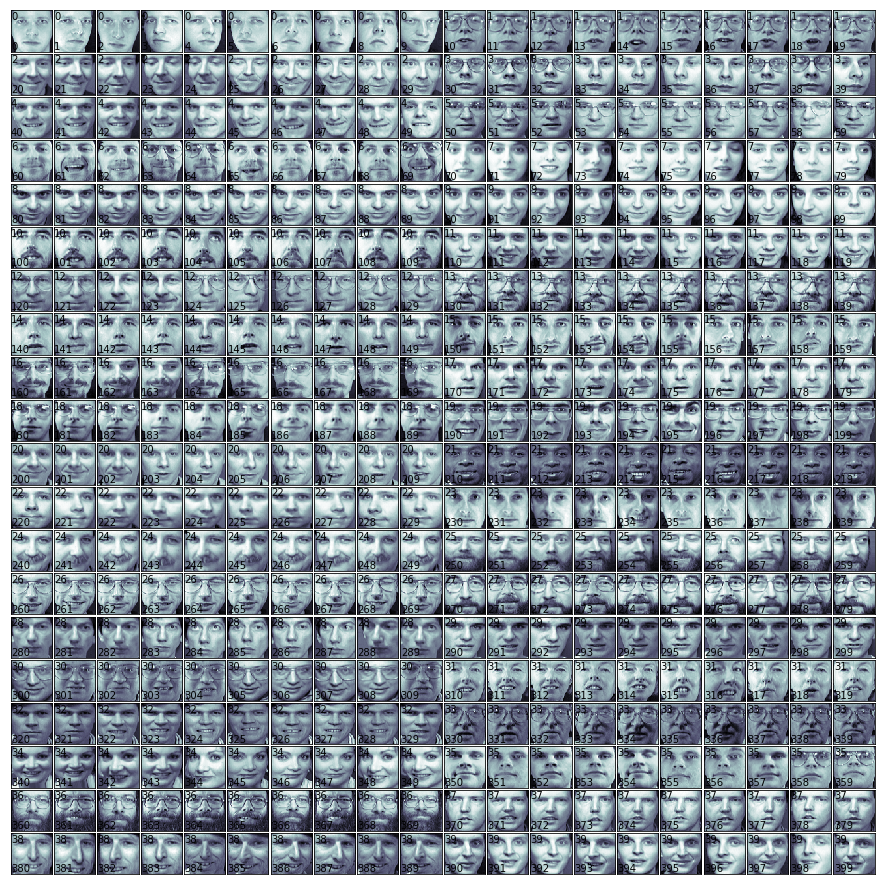

In [7]:
print_faces(faces.images, faces.target, 400)

我们将尝试构建一个分类器，该分类器的模型是一个超平面，它将一个类的实例（样本点）与其他类的实例（样本点）分开。 支持向量机（Support Vector Machine，SVM）是一种监督学习方法，通过选择经过不同类别实例之间最大可能间隔（边缘）的方法，尝试以最佳方式获得这些超平面。新的实例将被归类为属于某个类别，基于它们所在的超平面的哪一侧。从sklearn.svm模块导入SVC类。 SVC代表支持向量分类器：我们将使用SVM进行分类。

In [8]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')
print(svc_1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### SVC()函数的参数说明：

**C：惩罚系数: **
C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，这样对训练集测试时准确率很高，但泛化能力弱。C值小，对误分类的惩罚减小，允许容错，将他们当成噪声点，泛化能力较强。默认值是1.0

**cache_size：**核函数cache缓存大小，默认为200

**class_weight：样本权重：**
指定样本各类别的的权重，主要是为了防止训练集某些类别的样本过多，导致训练的决策过于偏向这些类别。
balanced：算法会自己计算权重，样本量少的类别所对应的样本权重会高。
None（默认）：样本类别分布没有明显的偏倚
自定义各个样本的权重

**coef0：poly和sigmoid核函数参数：**
核函数的常数项。对于‘poly’和 ‘sigmoid’有用

**decision_function_shape：分类决策的方式：**
OvR(one ve rest)：无论多少元分类，都做二元分类。具体做法是，对于第K类的分类决策，我们把所有第K类的样本作为正例，除了第K类样本以外的所有样本都作为负例，得到第K类的分类模型。其他类的分类模型获得以此类推。
OvO(one-vs-one)：所有的T类样本里面选择两类样本出来，记为T1类和T2类，把T1作为正例，T2作为负例，进行二元分类，得到模型参数。一共需要T(T-1)/2次分类。
OvR相对简单，但分类效果相对略差（这里指大多数样本分布情况，而OvO分类相对精确，但是分类速度没有OvR快。一般建议使用OvO以达到较好的分类效果。

**degree：poly核函数参数：**
多项式poly函数的维度，默认是3，选择其他核函数时会被忽略。

**gamma: rbf,poly和sigmoid的核函数参数： **
默认是’auto’，值是$\frac{1}{样本特征数}$
核函数的参数$\gamma$。回忆下RBF 核函数$K(x, z) = exp(-\gamma||x-z||^2)\;\;\gamma>0$，$\gamma$主要定义了单个样本对整个分类超平面的影响，当$\gamma$比较小时，单个样本对整个分类超平面的影响比较小，不容易被选择为支持向量，反之，当$\gamma$比较大时，单个样本对整个分类超平面的影响比较大，更容易被选择为支持向量，或者说整个模型的支持向量也会多。scikit-learn中默认值是$\frac{1}{样本特征数}$

**kernel：核函数**

默认是rbf，可以是‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’<br> 
0 – 线性核函数：linear <br>
1 – 多项式：poly 公式是 (gamma*u'*v + coef0)^degree <br>
2 – RBF函数：rbf 公式是 exp(-gamma|u-v|^2)  <br>
3 –sigmoid：公式是 tanh(gamma*u'*v + coef0)  <br>

**max_iter：**最大迭代次数：-1为无限制 

**tol：** 停止训练的误差值大小，默认为1e-3

**verbose ：**允许冗余输出，默认为False

**random_state ：**数据洗牌时的种子值，int值，默认为None

**shrinking ：**是否采用shrinking heuristic方法，默认为true

构造训练集和测试集

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        faces.data, faces.target, test_size=0.25, random_state=0)

执行 5-折 交叉验证（cross-validation）

In [10]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print(("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[0.93333333 0.86666667 0.91666667 0.93333333 0.91666667]
Mean score: 0.913 (+/-0.012)


In [12]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

测量每个类（共40个人，40类）在评估集上的精度和召回率

In [13]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.99
Classification Report:
             precision    recall  f1-score   support

          0       0.86      1.00      0.92         6
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         1
          4       1.00      1.00      1.00         1
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         4
          7       1.00      0.67      0.80         3
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       1.00      1.00      1.00         3
         17       1.00      1.00      1.00         6
         19    

辨别有或没有眼镜的人

在人脸识别上的表现非常好。 现在，还有一个问题：让我们尝试对有和没有眼镜的人的图像进行分类。我们人工标记戴眼镜的人。

In [15]:
# 下面是图片中的索引范围，代表是戴眼镜的人
glasses = [
	(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
	(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
	(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
	(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
	(330, 339), (358, 359), (360, 369)
]

为新问题创建训练集和测试集

In [16]:
def create_target(segments):
    # 创建一个新的目标字段，大小等同原目标字段，用0初始化
    y = np.zeros(faces.target.shape[0])
    # 将指定的片段赋值1
    for (start, end) in segments:
        y[start:end + 1] = 1
    return y

In [17]:
target_glasses = create_target(glasses)

X_train, X_test, y_train, y_test = train_test_split(
        faces.data, target_glasses, test_size=0.25, random_state=0)

还是用线性支持向量机来分类

In [18]:
svc_2 = SVC(kernel='linear')
evaluate_cross_validation(svc_2, X_train, y_train, 5)
train_and_evaluate(svc_2, X_train, X_test, y_train, y_test)

[1.         0.95       0.98333333 0.98333333 0.93333333]
Mean score: 0.970 (+/-0.012)
Accuracy on training set:
1.0
Accuracy on testing set:
0.99
Classification Report:
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99        67
        1.0       0.97      1.00      0.99        33

avg / total       0.99      0.99      0.99       100

Confusion Matrix:
[[66  1]
 [ 0 33]]


几乎完美！ 现在，让我们分离10个完全不同的图像（全部来自同一个人，有时戴眼镜，有时不戴眼镜）。 为此，我们将试图放弃它记住的面孔，转而学习与眼镜有关的特征。我们将研究的主题定在索引30到39，并把它们分开。我们将训练和评估其余的390个实例。 之后，我们将再次评估分隔的10个实例。

In [19]:
X_test = faces.data[30:40]       #选择30-39这10属性数据，总共400个
y_test = target_glasses[30:40]   #选择30-39的类别数据，总共400个
print(X_test.shape)
print(y_test.shape[0])

(10, 4096)
10


In [20]:
select = np.ones(target_glasses.shape[0]) #初始化成400个1的1维ndarray 
select[30:40] = 0                         #其中30-39设为0

In [21]:
select[29:41]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [21]:
select == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [22]:
X_train = faces.data[select == 1]
y_train = target_glasses[select == 1]
print(X_train.shape)
print(y_train.shape)

(390, 4096)
(390,)


In [23]:
svc_3 = SVC(kernel='linear')
train_and_evaluate(svc_3, X_train, X_test, y_train, y_test)
y_pred = svc_3.predict(X_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.9
Classification Report:
             precision    recall  f1-score   support

        0.0       0.83      1.00      0.91         5
        1.0       1.00      0.80      0.89         5

avg / total       0.92      0.90      0.90        10

Confusion Matrix:
[[5 0]
 [1 4]]


显示我们的评估面孔和他们的预测类别。 八号脸被错误地分类为无眼镜（可能是因为他的眼睛闭上！）

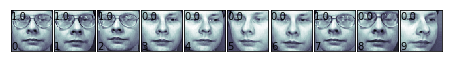

In [24]:
eval_faces = [np.reshape(a, (64, 64)) for a in X_test]
print_faces(eval_faces, y_pred, 10)